In [111]:
import pandas as pd
import re
import seaborn
import matplotlib.pyplot as plt
from textblob import TextBlob
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from wordcloud import WordCloud

In [112]:
text = pd.read_csv('tweet obama.csv') # read csv file
text.head()

,created_at,text,url,replies,retweets,favorites,user
0,10/16/17 22:59,I'm grateful to @SenJohnMcCain for his lifetim...,https://twitter.com/BarackObama/status/9200615...,17064,89916,641842,BarackObama
1,10/2/17 12:41,Michelle &amp; I are praying for the victims i...,https://twitter.com/BarackObama/status/9148326...,21588,405895,1715753,BarackObama
2,9/30/17 2:22,Proud to cheer on Team USA at the Invictus Gam...,https://twitter.com/BarackObama/status/9139520...,8476,60651,503255,BarackObama
3,9/26/17 17:03,We're expanding our efforts to help Puerto Ric...,https://twitter.com/BarackObama/status/9127244...,10657,113807,334901,BarackObama
4,9/25/17 23:36,"Prosecutor, soldier, family man, citizen. Beau...",https://twitter.com/BarackObama/status/9124608...,3886,58449,328106,BarackObama


### Data Preprocessing 

In [113]:
# check null values

text.isnull().sum()

created_at    0
text          0
url           0
replies       0
retweets      0
favorites     0
user          0
dtype: int64

In [114]:
# drop unnecessary files

df = text.drop(['created_at', 'url', 'replies', 'retweets', 'favorites', 'user'], axis=1)
df.head()

,text
0,I'm grateful to @SenJohnMcCain for his lifetim...
1,Michelle &amp; I are praying for the victims i...
2,Proud to cheer on Team USA at the Invictus Gam...
3,We're expanding our efforts to help Puerto Ric...
4,"Prosecutor, soldier, family man, citizen. Beau..."


### Data Cleaning

In [115]:
# data cleaning 

def data_processing(text):
    text = text.lower()
    text = re.sub(r"https\S+|www\S+https\S+", '',text, flags=re.MULTILINE) # remove URLs
    text = re.sub(r'\@w+|\#','',text) # remove special characters like @ and #
    text = re.sub(r'[^\w\s]','',text) # remove punctuation
    tokens = word_tokenize(text) # tokenize the text into words
    custom_stopwords = set(['https', 'http'])  # custom stopwords 
    filtered_tokens = [word for word in tokens if word not in stop_words and word not in custom_stopwords]
    filtered_text = [w for w in filtered_tokens if not w in stop_words]
    return " ".join(filtered_text)

In [116]:
df['cleaned text'] = df.text.apply(data_processing)

In [117]:
df.head()

,text,cleaned text
0,I'm grateful to @SenJohnMcCain for his lifetim...,im grateful senjohnmccain lifetime service cou...
1,Michelle &amp; I are praying for the victims i...,michelle amp praying victims las vegas thought...
2,Proud to cheer on Team USA at the Invictus Gam...,proud cheer team usa invictus games today frie...
3,We're expanding our efforts to help Puerto Ric...,expanding efforts help puerto rico amp usvi fe...
4,"Prosecutor, soldier, family man, citizen. Beau...",prosecutor soldier family man citizen beau mad...


In [118]:
print(df['cleaned text'].iloc[0], "\n")
print(df['cleaned text'].iloc[1], "\n")

im grateful senjohnmccain lifetime service country congratulations john receiving years liberty medal 

michelle amp praying victims las vegas thoughts families amp everyone enduring another senseless tragedy 



In [119]:
# tokenize the text data

df['tokenize_text'] = df['cleaned text'].apply(word_tokenize)

#### infrequent or rare words are noisy. They don't contain valuable information.

In [120]:
df['rmv_infrequent'] = df['tokenize_text'].apply(lambda x: ' '.join([item for item in x if len(item)>2]))
df.head()

,text,cleaned text,tokenize_text,rmv_infrequent
0,I'm grateful to @SenJohnMcCain for his lifetim...,im grateful senjohnmccain lifetime service cou...,"[im, grateful, senjohnmccain, lifetime, servic...",grateful senjohnmccain lifetime service countr...
1,Michelle &amp; I are praying for the victims i...,michelle amp praying victims las vegas thought...,"[michelle, amp, praying, victims, las, vegas, ...",michelle amp praying victims las vegas thought...
2,Proud to cheer on Team USA at the Invictus Gam...,proud cheer team usa invictus games today frie...,"[proud, cheer, team, usa, invictus, games, tod...",proud cheer team usa invictus games today frie...
3,We're expanding our efforts to help Puerto Ric...,expanding efforts help puerto rico amp usvi fe...,"[expanding, efforts, help, puerto, rico, amp, ...",expanding efforts help puerto rico amp usvi fe...
4,"Prosecutor, soldier, family man, citizen. Beau...",prosecutor soldier family man citizen beau mad...,"[prosecutor, soldier, family, man, citizen, be...",prosecutor soldier family man citizen beau mad...


### after remove rare or infrequent words, join all the words for frequency distributions

In [121]:
all_words = ' '.join([word for word in df['rmv_infrequent']])

In [122]:
from nltk.probability import FreqDist

tokenize = nltk.tokenize.word_tokenize(all_words)
frequency_distribution = FreqDist(tokenize)
frequency_distribution

FreqDist({'president': 1209, 'obama': 1069, 'actonclimate': 294, 'change': 215, 'watch': 207, 'hitehouse': 201, 'climate': 201, 'time': 174, 'health': 170, 'americans': 158, ...})

In [123]:
df['drop_words'] = df['tokenize_text'].apply(lambda x: ' '.join(word for word in x if frequency_distribution[word]>3))

In [124]:
print(df['drop_words'].iloc[0], "\n")
print(df['drop_words'].iloc[1], "\n")
print(df['drop_words'].iloc[2], "\n")

grateful service country congratulations john years 

michelle amp victims thoughts families amp everyone another 

proud team games today friend joe best country 



### Normalize text
 Now we have to normalize our text using NLP techniques. In this case we can use 'Lemmatization'

In [125]:
from nltk.stem import WordNetLemmatizer
lemma = WordNetLemmatizer()

df['lemmatize_words'] = df['drop_words'].apply(lemma.lemmatize)


In [126]:
print(df['lemmatize_words'].iloc[0], "\n")
print(df['lemmatize_words'].iloc[1], "\n")
print(df['lemmatize_words'].iloc[2], "\n")

grateful service country congratulations john years 

michelle amp victims thoughts families amp everyone another 

proud team games today friend joe best country 



#### TextBLob is a python library, with a strong focus on sentiment analysis.

In [127]:
def polarity(text):
    # polarity: A value between -1 (negative) and 1 (positive) indicating overall sentiment.
    return TextBlob(text).sentiment.polarity

In [128]:
df['polarity'] = df['drop_words'].apply(polarity)

In [129]:
df.head()

,text,cleaned text,tokenize_text,rmv_infrequent,drop_words,lemmatize_words,polarity
0,I'm grateful to @SenJohnMcCain for his lifetim...,im grateful senjohnmccain lifetime service cou...,"[im, grateful, senjohnmccain, lifetime, servic...",grateful senjohnmccain lifetime service countr...,grateful service country congratulations john ...,grateful service country congratulations john ...,0.000000
1,Michelle &amp; I are praying for the victims i...,michelle amp praying victims las vegas thought...,"[michelle, amp, praying, victims, las, vegas, ...",michelle amp praying victims las vegas thought...,michelle amp victims thoughts families amp eve...,michelle amp victims thoughts families amp eve...,0.000000
2,Proud to cheer on Team USA at the Invictus Gam...,proud cheer team usa invictus games today frie...,"[proud, cheer, team, usa, invictus, games, tod...",proud cheer team usa invictus games today frie...,proud team games today friend joe best country,proud team games today friend joe best country,0.900000
3,We're expanding our efforts to help Puerto Ric...,expanding efforts help puerto rico amp usvi fe...,"[expanding, efforts, help, puerto, rico, amp, ...",expanding efforts help puerto rico amp usvi fe...,expanding efforts help amp fellow americans ne...,expanding efforts help amp fellow americans ne...,0.285714
4,"Prosecutor, soldier, family man, citizen. Beau...",prosecutor soldier family man citizen beau mad...,"[prosecutor, soldier, family, man, citizen, be...",prosecutor soldier family man citizen beau mad...,family man citizen beau made want better legac...,family man citizen beau made want better legac...,0.500000


In [130]:
def sentiment(label):
    if label < 0:
        return 'Negative'
    elif label == 0:
        return 'Neutral'
    elif label > 0:
        return 'Positive'

In [131]:
df['sentiment'] = df['polarity'].apply(sentiment)

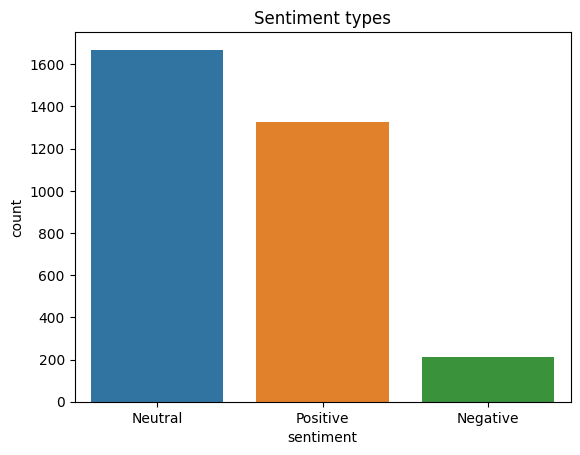

In [137]:
# make a chart of sentiment 

import seaborn as sns
sns.countplot(x = df['sentiment'])
plt.title('Sentiment types')
plt.show()

In [134]:
# counting each sentiment

df['sentiment'].value_counts() 

sentiment
Neutral     1669
Positive    1328
Negative     210
Name: count, dtype: int64

<Axes: >

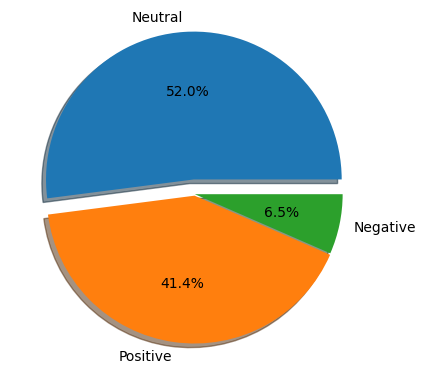

In [64]:
explode = (0.1, 0.01,0)
senti = df['sentiment'].value_counts()

senti.plot(kind='pie', autopct='%1.1f%%', shadow=True,
         explode=explode, label='')